# 说明
写在前面
此baseline能达到0.1417的分数，分数一般，可以帮助快速进入到比赛。使用的时lightGBM模型，特征使用了年，月，日三个特征。在此基础上继续加特征分数还能提升。另外训练策略将所有distrcit分开训练，当然还可以使用其它策略。

从不同角度去考虑问题，或许会另有一个新的天地

[链接](https://zhuanlan.zhihu.com/p/50623176?utm_source=com.tencent.tim&utm_medium=social&utm_oi=555381879923224576)

# 导入数据&数据探索

In [1]:
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,8
mpl.style.use('ggplot')
import numpy as np
from datetime import date
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
flow_train = pd.read_csv('./data/RawData/flow_train.csv')
tran_train = pd.read_csv('./data/RawData/transition_train.csv')

In [3]:
flow_train.head()

,date_dt,city_code,district_code,dwell,flow_in,flow_out
0,20170601,06d86ef037e4bd311b94467c3320ff38,85792b2278de59316d1158f6a97537ec,118.861740,54.421293,52.089701
1,20170601,5615dc7c1af1f7dabd80bd8b8ecb1ea0,1d86aa481642ba64ef42e2956339bbad,130.333409,235.490857,231.275943
2,20170601,c7537db4101856877ea6381d0174283c,08751b85e3dc67f2e690cf8945a4d85b,98.698267,57.672715,54.252464
3,20170601,5615dc7c1af1f7dabd80bd8b8ecb1ea0,50ec193f67e23ca084bb7af4100c1243,280.984567,571.333345,555.579813
4,20170601,3f7f0ce35d6d0a08377eb2efe2189f4f,dad5b1a26517a039827215846bcaf394,99.126162,72.334678,69.968155


In [4]:
flow_train.tail()

,date_dt,city_code,district_code,dwell,flow_in,flow_out
26847,20180301,a20d041605db832309e26c003c626719,eed0d29bb4d08163ddd02c629a51cfb7,367.413591,707.750435,713.595426
26848,20180301,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,94.157337,72.468577,71.240198
26849,20180301,a20d041605db832309e26c003c626719,ac12452bc2dff4b1d376ed517b9f74f4,2343.931746,3969.668920,4039.904873
26850,20180301,58a33c947775af5de36841c9f553317d,05e37aecd15e7e3f7fb6dbb8e4713837,110.350408,71.173248,73.237042
26851,20180301,a20d041605db832309e26c003c626719,879c99a1536ce81df8e84c0c9cf6ff68,1787.010031,3400.835997,3437.407944


In [5]:
flow_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26852 entries, 0 to 26851
Data columns (total 6 columns):
date_dt          26852 non-null int64
city_code        26852 non-null object
district_code    26852 non-null object
dwell            26852 non-null float64
flow_in          26852 non-null float64
flow_out         26852 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ MB


98个地区

In [6]:
# 查看特定城市特定地区的数据
# 这里需要用&，而不是and
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='85792b2278de59316d1158f6a97537ec')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 0 to 26841
Data columns (total 6 columns):
date_dt          274 non-null int64
city_code        274 non-null object
district_code    274 non-null object
dwell            274 non-null float64
flow_in          274 non-null float64
flow_out         274 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 15.0+ KB


In [7]:
# 查看有哪些城市，城市数量 = 7
#flow_train['city_code'].count()
flow_train['city_code'].value_counts()

c7537db4101856877ea6381d0174283c    6028
3f7f0ce35d6d0a08377eb2efe2189f4f    6028
a20d041605db832309e26c003c626719    4384
58a33c947775af5de36841c9f553317d    4384
06d86ef037e4bd311b94467c3320ff38    3014
5615dc7c1af1f7dabd80bd8b8ecb1ea0    2740
ee2ff207184bf16b4a0aec0f97900c27     274
Name: city_code, dtype: int64

In [8]:
# 查看城市 '06d86ef037e4bd311b94467c3320ff38'里面各个区县的数量，11个
flow_train[flow_train['city_code'] ==
           '06d86ef037e4bd311b94467c3320ff38']['district_code'].value_counts()

663c41e93447911aaeb2bded1ecdd918    274
7809f7e1ce419a80532cf5917f9b34c0    274
4fe4bd4a69e1d7a5550d28ef71c8dcaa    274
077ff638b4c221fc3abb88fa9bd499a7    274
4d3b1591070ad975f4c0b7232485980d    274
ccbf7a1a33c7c6926366ba5f6e2f1e83    274
85792b2278de59316d1158f6a97537ec    274
76aa9284408ba09d7069f226d6b86a31    274
a07711a54a122bee09726fc7489f2c1b    274
032c75c11f45ab3abf41506d616af280    274
3a3630930e4f054033e0c64a728f759a    274
Name: district_code, dtype: int64

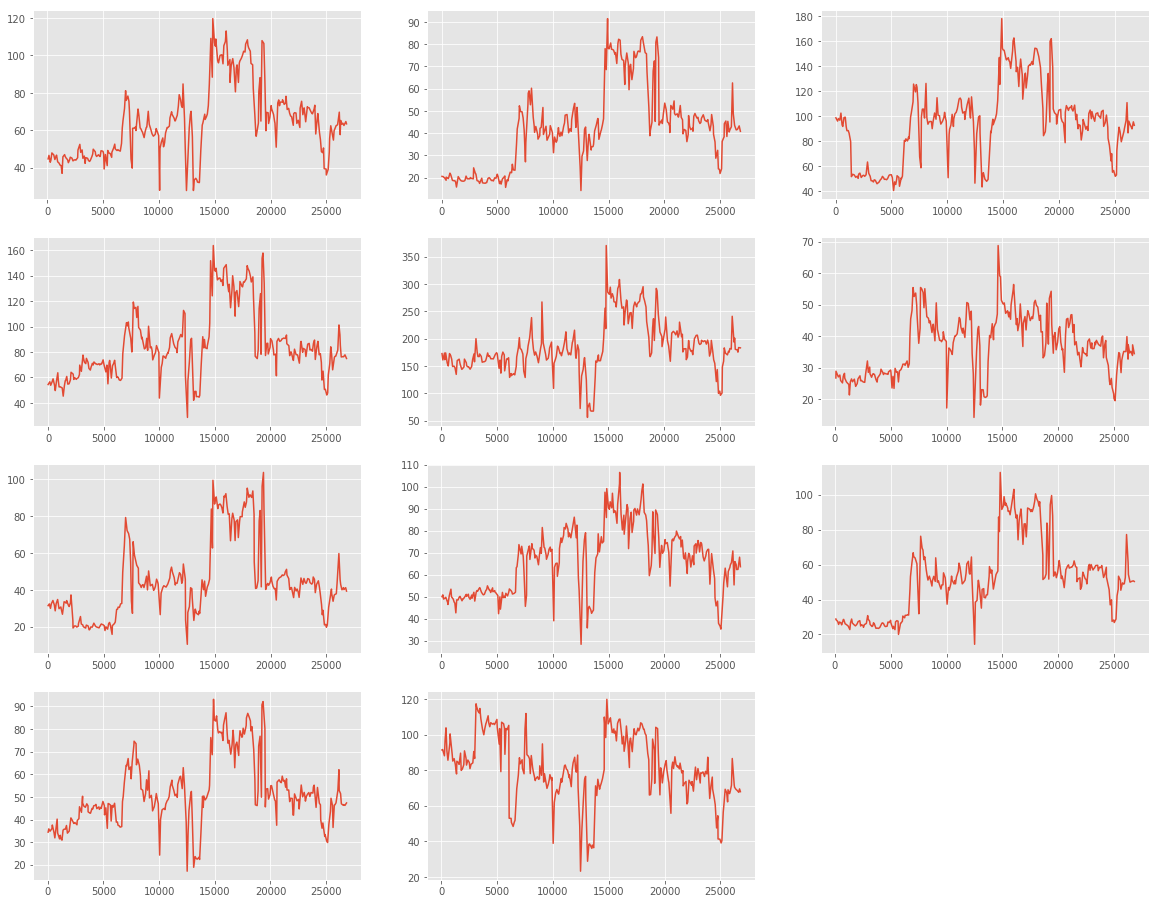

In [9]:
# 绘制城市06d86ef037e4bd311b94467c3320ff38不同区县的人口流入图
# 这里图的尺寸需要大一点
plt.rcParams['figure.figsize'] = 20,16
plt.subplot(4,3,1)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='663c41e93447911aaeb2bded1ecdd918')]['flow_in'].plot()
plt.subplot(4,3,2)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='a07711a54a122bee09726fc7489f2c1b')]['flow_in'].plot()
plt.subplot(4,3,3)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='ccbf7a1a33c7c6926366ba5f6e2f1e83')]['flow_in'].plot()
plt.subplot(4,3,4)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='85792b2278de59316d1158f6a97537ec')]['flow_in'].plot()
plt.subplot(4,3,5)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='4d3b1591070ad975f4c0b7232485980d')]['flow_in'].plot()
plt.subplot(4,3,6)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='7809f7e1ce419a80532cf5917f9b34c0')]['flow_in'].plot()
plt.subplot(4,3,7)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='032c75c11f45ab3abf41506d616af280')]['flow_in'].plot()
plt.subplot(4,3,8)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='3a3630930e4f054033e0c64a728f759a')]['flow_in'].plot()
plt.subplot(4,3,9)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='4fe4bd4a69e1d7a5550d28ef71c8dcaa')]['flow_in'].plot()
plt.subplot(4,3,10)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='077ff638b4c221fc3abb88fa9bd499a7')]['flow_in'].plot()
plt.subplot(4,3,11)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='76aa9284408ba09d7069f226d6b86a31')]['flow_in'].plot()
plt.rcParams['figure.figsize'] = 10,8

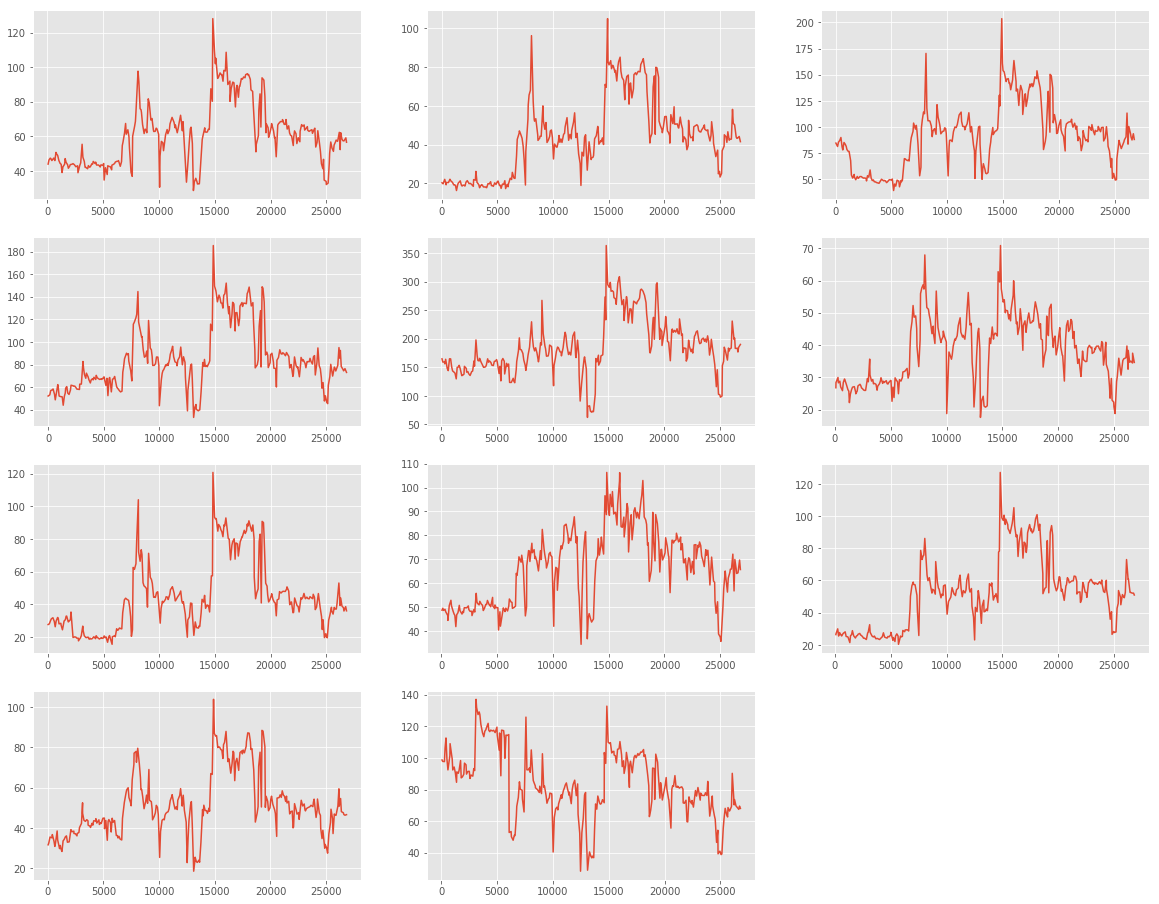

In [10]:
# 绘制城市06d86ef037e4bd311b94467c3320ff38不同区县的人口流出图
# 这里图的尺寸需要大一点
plt.rcParams['figure.figsize'] = 20,16
plt.subplot(4,3,1)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='663c41e93447911aaeb2bded1ecdd918')]['flow_out'].plot()
plt.subplot(4,3,2)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='a07711a54a122bee09726fc7489f2c1b')]['flow_out'].plot()
plt.subplot(4,3,3)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='ccbf7a1a33c7c6926366ba5f6e2f1e83')]['flow_out'].plot()
plt.subplot(4,3,4)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='85792b2278de59316d1158f6a97537ec')]['flow_out'].plot()
plt.subplot(4,3,5)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='4d3b1591070ad975f4c0b7232485980d')]['flow_out'].plot()
plt.subplot(4,3,6)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='7809f7e1ce419a80532cf5917f9b34c0')]['flow_out'].plot()
plt.subplot(4,3,7)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='032c75c11f45ab3abf41506d616af280')]['flow_out'].plot()
plt.subplot(4,3,8)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='3a3630930e4f054033e0c64a728f759a')]['flow_out'].plot()
plt.subplot(4,3,9)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='4fe4bd4a69e1d7a5550d28ef71c8dcaa')]['flow_out'].plot()
plt.subplot(4,3,10)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='077ff638b4c221fc3abb88fa9bd499a7')]['flow_out'].plot()
plt.subplot(4,3,11)
flow_train[(flow_train['city_code']=='06d86ef037e4bd311b94467c3320ff38') & 
           (flow_train['district_code']=='76aa9284408ba09d7069f226d6b86a31')]['flow_out'].plot()
plt.rcParams['figure.figsize'] = 10,8

In [11]:
tran_train.head()

,date_dt,o_city_code,o_district_code,d_city_code,d_district_code,cnt
0,20170601,a20d041605db832309e26c003c626719,879c99a1536ce81df8e84c0c9cf6ff68,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,0.008733
1,20170601,c7537db4101856877ea6381d0174283c,82271c9f4c9bf3b072ebe43b29d01caf,c7537db4101856877ea6381d0174283c,4a2ee3a671acbb271743ca0abbcadc70,2.066705
2,20170601,5615dc7c1af1f7dabd80bd8b8ecb1ea0,2d9ca395c9405028ca5d6635253d7166,a20d041605db832309e26c003c626719,01c2fa70527b0c72808f3bc27eaad4c9,0.177562
3,20170601,a20d041605db832309e26c003c626719,cc000ec2dd2b1c6571e74cecc641656e,58a33c947775af5de36841c9f553317d,0b28636d08bff292de12f663d522c55f,0.113523
4,20170601,c7537db4101856877ea6381d0174283c,3f92d69b5335d09f3365beaeec3da4b8,58a33c947775af5de36841c9f553317d,0b28636d08bff292de12f663d522c55f,0.058217


In [12]:
tran_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480320 entries, 0 to 2480319
Data columns (total 6 columns):
date_dt            int64
o_city_code        object
o_district_code    object
d_city_code        object
d_district_code    object
cnt                float64
dtypes: float64(1), int64(1), object(4)
memory usage: 113.5+ MB


# 帮助函数

In [13]:
def year(date):
    date = str(date)
    return int(date[0:4])
def month(date):
    date = str(date)
    return int(date[4:6])
def day(date):
    date = str(date)
    return int(date[6:8])

# 建模

In [14]:
flow_train['year'] = flow_train['date_dt'].apply(year)
flow_train['month'] = flow_train['date_dt'].apply(month)
flow_train['day'] = flow_train['date_dt'].apply(day)

flow_train['address'] = flow_train['city_code']+':'+flow_train['district_code']
address = list(set(flow_train['address']))

# 划分训练集和验证集
# 训练集数量25284，验证集数量1568，比例是16:1
flow_train_1 = flow_train[flow_train['date_dt'] < 20180214]
flow_test_1 = flow_train[flow_train['date_dt'] >= 20180214]

label = ['dwell','flow_in','flow_out']
feature = ['year','month','day']

def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

star = '20180301'
dates = []
for i in range(1,16):
    date_format = datetime.datetime.strptime(star,'%Y%m%d')
    fut_date = date_format + datetime.timedelta(days=i)
    dates.append(int(datetime.datetime.strftime(fut_date,'%Y%m%d')))
test_df = pd.DataFrame({'date_dt':dates})
test_df['year'] = test_df['date_dt'].apply(year)
test_df['month'] = test_df['date_dt'].apply(month)
test_df['day'] = test_df['date_dt'].apply(day)
test_df['date_dt'] = test_df['date_dt'].astype(str)

result = pd.DataFrame(columns=['date_dt', 'city_code', 'district_code', 'dwell', 'flow_in', 'flow_out'])

for ad in address:
    ad_split = ad.split(':')
    test_df['city_code'] = ad_split[0]
    test_df['district_code'] = ad_split[1]
    for y in label:
        train_x = flow_train[flow_train['address']==ad][feature]
        train_y = flow_train[flow_train['address']==ad][y]
        test_x = flow_test_1[flow_test_1['address']==ad][feature]
        test_y = flow_test_1[flow_test_1['address']==ad][y]
        # Use traditional Gradient Boosting Decision Tree to build model
        # Which one is the best, gbdt, dart, goss, or rf?
        gbm = lgb.LGBMRegressor(num_leaves=50,
                        learning_rate=0.05,
                        n_estimators=1000)
        gbm.fit(train_x, train_y, 
                eval_set=[(test_x, test_y)],
                eval_metric='l1',
                early_stopping_rounds=5)
        # predict
        y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration_)
        # eval
        print('The rmsle of prediction is:', rmsle(test_y, y_pred)[1])
        test_df[y] = gbm.predict(test_df[feature])
    result = pd.concat([result,test_df[result.columns]])

result['date_dt'] = result['date_dt'].astype(int)
result = result[['date_dt', 'city_code', 'district_code', 'dwell', 'flow_in', 'flow_out']]
result.to_csv('prediction.csv', index=False, header=None)

[1]	valid_0's l1: 166.017	valid_0's l2: 28997.4
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 159.197	valid_0's l2: 26744.6
[3]	valid_0's l1: 152.091	valid_0's l2: 24532.7
[4]	valid_0's l1: 145.901	valid_0's l2: 22657.4
[5]	valid_0's l1: 139.422	valid_0's l2: 20808.9
[6]	valid_0's l1: 133.801	valid_0's l2: 19246.5
[7]	valid_0's l1: 127.891	valid_0's l2: 17700
[8]	valid_0's l1: 122.786	valid_0's l2: 16397
[9]	valid_0's l1: 117.393	valid_0's l2: 15101.7
[10]	valid_0's l1: 112.754	valid_0's l2: 14014
[11]	valid_0's l1: 107.83	valid_0's l2: 12927.8
[12]	valid_0's l1: 103.614	valid_0's l2: 12019
[13]	valid_0's l1: 99.116	valid_0's l2: 11107.1
[14]	valid_0's l1: 95.2834	valid_0's l2: 10347.1
[15]	valid_0's l1: 91.1718	valid_0's l2: 9580.41
[16]	valid_0's l1: 87.6862	valid_0's l2: 8944.21
[17]	valid_0's l1: 83.926	valid_0's l2: 8298.92
[18]	valid_0's l1: 80.7547	valid_0's l2: 7765.85
[19]	valid_0's l1: 77.3141	valid_0's l2: 7221.99
[20]	valid_0's l1: 74.4277	v

The rmsle of prediction is: 0.09567367007152018
[1]	valid_0's l1: 14.7641	valid_0's l2: 277.03
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 14.5465	valid_0's l2: 270.653
[3]	valid_0's l1: 14.3399	valid_0's l2: 264.683
[4]	valid_0's l1: 14.1435	valid_0's l2: 259.091
[5]	valid_0's l1: 13.957	valid_0's l2: 253.849
[6]	valid_0's l1: 13.7798	valid_0's l2: 248.934
[7]	valid_0's l1: 13.4774	valid_0's l2: 240.543
[8]	valid_0's l1: 13.2906	valid_0's l2: 235.698
[9]	valid_0's l1: 13.0126	valid_0's l2: 228.237
[10]	valid_0's l1: 12.8484	valid_0's l2: 224.142
[11]	valid_0's l1: 12.5923	valid_0's l2: 217.483
[12]	valid_0's l1: 12.4484	valid_0's l2: 214.029
[13]	valid_0's l1: 12.2123	valid_0's l2: 208.061
[14]	valid_0's l1: 12.0865	valid_0's l2: 205.157
[15]	valid_0's l1: 11.8685	valid_0's l2: 199.788
[16]	valid_0's l1: 11.7592	valid_0's l2: 197.356
[17]	valid_0's l1: 11.5574	valid_0's l2: 192.506
[18]	valid_0's l1: 11.4629	valid_0's l2: 190.481
[19]	valid_0's l1: 1

[1]	valid_0's l1: 14.6526	valid_0's l2: 243.561
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 15.1564	valid_0's l2: 258.488
[3]	valid_0's l1: 15.033	valid_0's l2: 254.761
[4]	valid_0's l1: 15.4958	valid_0's l2: 269.157
[5]	valid_0's l1: 15.3659	valid_0's l2: 265.147
[6]	valid_0's l1: 15.7913	valid_0's l2: 278.967
Early stopping, best iteration is:
[1]	valid_0's l1: 14.6526	valid_0's l2: 243.561
The rmsle of prediction is: 0.10507100202766098
[1]	valid_0's l1: 53.4119	valid_0's l2: 2956.81
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 51.5199	valid_0's l2: 2758.28
[3]	valid_0's l1: 49.7225	valid_0's l2: 2576.31
[4]	valid_0's l1: 48.015	valid_0's l2: 2409.42
[5]	valid_0's l1: 46.3929	valid_0's l2: 2256.28
[6]	valid_0's l1: 44.8519	valid_0's l2: 2115.67
[7]	valid_0's l1: 43.3879	valid_0's l2: 1986.49
[8]	valid_0's l1: 41.9971	valid_0's l2: 1867.74
[9]	valid_0's l1: 40.6759	valid_0's l2: 1758.51
[10]	valid_0's l1: 39.4207	va

The rmsle of prediction is: 0.0638534370245942
[1]	valid_0's l1: 314.78	valid_0's l2: 124957
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 304.965	valid_0's l2: 117261
[3]	valid_0's l1: 295.64	valid_0's l2: 110267
[4]	valid_0's l1: 287.47	valid_0's l2: 103909
[5]	valid_0's l1: 281.723	valid_0's l2: 98127.8
[6]	valid_0's l1: 276.393	valid_0's l2: 92868.7
[7]	valid_0's l1: 271.33	valid_0's l2: 88083
[8]	valid_0's l1: 266.52	valid_0's l2: 83726.5
[9]	valid_0's l1: 262.087	valid_0's l2: 80256.4
[10]	valid_0's l1: 257.64	valid_0's l2: 76524.9
[11]	valid_0's l1: 253.546	valid_0's l2: 73573.2
[12]	valid_0's l1: 249.432	valid_0's l2: 70373.2
[13]	valid_0's l1: 245.648	valid_0's l2: 67861.4
[14]	valid_0's l1: 241.84	valid_0's l2: 65114
[15]	valid_0's l1: 238.34	valid_0's l2: 62976
[16]	valid_0's l1: 234.811	valid_0's l2: 60614.5
[17]	valid_0's l1: 231.572	valid_0's l2: 58794.3
[18]	valid_0's l1: 228.299	valid_0's l2: 56762.3
[19]	valid_0's l1: 225.299	valid_0's 

[1]	valid_0's l1: 200.733	valid_0's l2: 42390.2
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 191.986	valid_0's l2: 38955.1
[3]	valid_0's l1: 183.677	valid_0's l2: 35833.5
[4]	valid_0's l1: 175.783	valid_0's l2: 32995.9
[5]	valid_0's l1: 168.283	valid_0's l2: 30415.6
[6]	valid_0's l1: 161.159	valid_0's l2: 28068.5
[7]	valid_0's l1: 154.391	valid_0's l2: 25932.8
[8]	valid_0's l1: 147.961	valid_0's l2: 23988.8
[9]	valid_0's l1: 141.853	valid_0's l2: 22218.5
[10]	valid_0's l1: 136.05	valid_0's l2: 20605.9
[11]	valid_0's l1: 130.537	valid_0's l2: 19136.3
[12]	valid_0's l1: 125.3	valid_0's l2: 17796.4
[13]	valid_0's l1: 120.325	valid_0's l2: 16574.4
[14]	valid_0's l1: 115.598	valid_0's l2: 15459.3
[15]	valid_0's l1: 111.108	valid_0's l2: 14441.4
[16]	valid_0's l1: 106.842	valid_0's l2: 13511.7
[17]	valid_0's l1: 102.79	valid_0's l2: 12662.2
[18]	valid_0's l1: 98.9403	valid_0's l2: 11885.6
[19]	valid_0's l1: 95.2831	valid_0's l2: 11175.2
[20]	valid_0's l1: 92

The rmsle of prediction is: 0.08998379309827335
[1]	valid_0's l1: 8.29461	valid_0's l2: 95.2116
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 8.29848	valid_0's l2: 94.5234
[3]	valid_0's l1: 8.30215	valid_0's l2: 94.2963
[4]	valid_0's l1: 8.31063	valid_0's l2: 94.4656
[5]	valid_0's l1: 8.41273	valid_0's l2: 94.974
[6]	valid_0's l1: 8.50973	valid_0's l2: 95.7706
Early stopping, best iteration is:
[1]	valid_0's l1: 8.29461	valid_0's l2: 95.2116
The rmsle of prediction is: 0.09150463029892239
[1]	valid_0's l1: 12.5927	valid_0's l2: 265.781
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 12.4451	valid_0's l2: 261.567
[3]	valid_0's l1: 12.305	valid_0's l2: 257.616
[4]	valid_0's l1: 12.5805	valid_0's l2: 265.886
[5]	valid_0's l1: 12.4206	valid_0's l2: 261.889
[6]	valid_0's l1: 12.7228	valid_0's l2: 269.825
[7]	valid_0's l1: 12.5706	valid_0's l2: 265.81
[8]	valid_0's l1: 12.8578	valid_0's l2: 273.404
Early stopping, best iteration

[68]	valid_0's l1: 323.624	valid_0's l2: 139429
[69]	valid_0's l1: 322.698	valid_0's l2: 139209
[70]	valid_0's l1: 321.627	valid_0's l2: 138499
[71]	valid_0's l1: 320.788	valid_0's l2: 138305
[72]	valid_0's l1: 319.748	valid_0's l2: 137634
[73]	valid_0's l1: 318.965	valid_0's l2: 137280
[74]	valid_0's l1: 318.251	valid_0's l2: 137117
[75]	valid_0's l1: 316.818	valid_0's l2: 136727
[76]	valid_0's l1: 316.103	valid_0's l2: 136430
[77]	valid_0's l1: 314.565	valid_0's l2: 135217
[78]	valid_0's l1: 313.236	valid_0's l2: 134852
[79]	valid_0's l1: 312.455	valid_0's l2: 134463
[80]	valid_0's l1: 311.951	valid_0's l2: 134358
[81]	valid_0's l1: 310.766	valid_0's l2: 134094
[82]	valid_0's l1: 310.153	valid_0's l2: 133864
[83]	valid_0's l1: 308.688	valid_0's l2: 132665
[84]	valid_0's l1: 308.328	valid_0's l2: 132303
[85]	valid_0's l1: 307.234	valid_0's l2: 132063
[86]	valid_0's l1: 306.319	valid_0's l2: 130615
[87]	valid_0's l1: 305.484	valid_0's l2: 129382
[88]	valid_0's l1: 304.339	valid_0's l2:

The rmsle of prediction is: 0.06904657274379859
[1]	valid_0's l1: 4.47067	valid_0's l2: 61.398
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 4.44966	valid_0's l2: 61.4629
[3]	valid_0's l1: 4.48061	valid_0's l2: 61.663
[4]	valid_0's l1: 4.53362	valid_0's l2: 62.2689
[5]	valid_0's l1: 4.62157	valid_0's l2: 62.9332
[6]	valid_0's l1: 4.71255	valid_0's l2: 63.382
Early stopping, best iteration is:
[1]	valid_0's l1: 4.47067	valid_0's l2: 61.398
The rmsle of prediction is: 0.09840277423083124
[1]	valid_0's l1: 5.53227	valid_0's l2: 62.8614
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 5.60246	valid_0's l2: 63.2581
[3]	valid_0's l1: 5.69049	valid_0's l2: 64.0286
[4]	valid_0's l1: 5.75292	valid_0's l2: 64.4621
[5]	valid_0's l1: 5.83174	valid_0's l2: 65.2065
[6]	valid_0's l1: 5.88724	valid_0's l2: 65.6579
Early stopping, best iteration is:
[1]	valid_0's l1: 5.53227	valid_0's l2: 62.8614
The rmsle of prediction is: 0.10248622256780

The rmsle of prediction is: 0.08368267322632957
[1]	valid_0's l1: 11.9463	valid_0's l2: 202.429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 11.8288	valid_0's l2: 196.011
[3]	valid_0's l1: 11.7172	valid_0's l2: 190.129
[4]	valid_0's l1: 11.506	valid_0's l2: 183.568
[5]	valid_0's l1: 11.4049	valid_0's l2: 178.532
[6]	valid_0's l1: 11.2112	valid_0's l2: 172.971
[7]	valid_0's l1: 11.1196	valid_0's l2: 168.644
[8]	valid_0's l1: 11.0325	valid_0's l2: 164.664
[9]	valid_0's l1: 10.8689	valid_0's l2: 160.269
[10]	valid_0's l1: 10.7901	valid_0's l2: 156.84
[11]	valid_0's l1: 10.6743	valid_0's l2: 154.27
[12]	valid_0's l1: 10.6582	valid_0's l2: 153.245
[13]	valid_0's l1: 10.5876	valid_0's l2: 150.38
[14]	valid_0's l1: 10.489	valid_0's l2: 148.346
[15]	valid_0's l1: 10.4763	valid_0's l2: 147.61
[16]	valid_0's l1: 10.4642	valid_0's l2: 146.93
[17]	valid_0's l1: 10.3778	valid_0's l2: 145.279
[18]	valid_0's l1: 10.318	valid_0's l2: 143.058
[19]	valid_0's l1: 10.3085

The rmsle of prediction is: 0.1192346643144104
[1]	valid_0's l1: 10.2599	valid_0's l2: 161.32
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 10.0556	valid_0's l2: 155.557
[3]	valid_0's l1: 9.94909	valid_0's l2: 150.872
[4]	valid_0's l1: 9.76439	valid_0's l2: 145.983
[5]	valid_0's l1: 9.668	valid_0's l2: 141.943
[6]	valid_0's l1: 9.62891	valid_0's l2: 140.21
[7]	valid_0's l1: 9.4683	valid_0's l2: 136.24
[8]	valid_0's l1: 9.43388	valid_0's l2: 134.792
[9]	valid_0's l1: 9.35224	valid_0's l2: 131.641
[10]	valid_0's l1: 9.21253	valid_0's l2: 128.387
[11]	valid_0's l1: 9.18672	valid_0's l2: 127.319
[12]	valid_0's l1: 9.12489	valid_0's l2: 124.699
[13]	valid_0's l1: 9.113	valid_0's l2: 123.826
[14]	valid_0's l1: 9.00394	valid_0's l2: 121.236
[15]	valid_0's l1: 8.9936	valid_0's l2: 120.506
[16]	valid_0's l1: 8.93938	valid_0's l2: 118.396
[17]	valid_0's l1: 8.8436	valid_0's l2: 116.227
[18]	valid_0's l1: 8.83559	valid_0's l2: 115.696
[19]	valid_0's l1: 8.82798	va

The rmsle of prediction is: 0.05586578476284987
[1]	valid_0's l1: 4.56677	valid_0's l2: 50.9734
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 4.54428	valid_0's l2: 51.3653
[3]	valid_0's l1: 4.578	valid_0's l2: 51.9902
[4]	valid_0's l1: 4.64373	valid_0's l2: 52.8117
[5]	valid_0's l1: 4.70617	valid_0's l2: 53.7978
[6]	valid_0's l1: 4.76548	valid_0's l2: 54.9203
Early stopping, best iteration is:
[1]	valid_0's l1: 4.56677	valid_0's l2: 50.9734
The rmsle of prediction is: 0.07723972451627896
[1]	valid_0's l1: 6.76102	valid_0's l2: 75.5064
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 6.8958	valid_0's l2: 77.6635
[3]	valid_0's l1: 7.02384	valid_0's l2: 79.7872
[4]	valid_0's l1: 7.14548	valid_0's l2: 81.8718
[5]	valid_0's l1: 7.26103	valid_0's l2: 83.9128
[6]	valid_0's l1: 7.38625	valid_0's l2: 85.9064
Early stopping, best iteration is:
[1]	valid_0's l1: 6.76102	valid_0's l2: 75.5064
The rmsle of prediction is: 0.0918977959375

[1]	valid_0's l1: 32.5308	valid_0's l2: 1504.79
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.792	valid_0's l2: 1444.55
[3]	valid_0's l1: 31.0902	valid_0's l2: 1389.03
[4]	valid_0's l1: 30.5212	valid_0's l2: 1337.8
[5]	valid_0's l1: 30.03	valid_0's l2: 1290.52
[6]	valid_0's l1: 29.5633	valid_0's l2: 1246.85
[7]	valid_0's l1: 29.1178	valid_0's l2: 1212.73
[8]	valid_0's l1: 28.6972	valid_0's l2: 1175.27
[9]	valid_0's l1: 28.2956	valid_0's l2: 1146.14
[10]	valid_0's l1: 27.9165	valid_0's l2: 1113.92
[11]	valid_0's l1: 27.5546	valid_0's l2: 1088.99
[12]	valid_0's l1: 27.2129	valid_0's l2: 1061.2
[13]	valid_0's l1: 26.8867	valid_0's l2: 1039.8
[14]	valid_0's l1: 26.6845	valid_0's l2: 1025.19
[15]	valid_0's l1: 26.3943	valid_0's l2: 1002.71
[16]	valid_0's l1: 26.2195	valid_0's l2: 990.492
[17]	valid_0's l1: 25.9583	valid_0's l2: 974.808
[18]	valid_0's l1: 25.8078	valid_0's l2: 964.579
[19]	valid_0's l1: 25.7142	valid_0's l2: 954.027
[20]	valid_0's l1: 25.4

The rmsle of prediction is: 0.033601100350569374
[1]	valid_0's l1: 37.5874	valid_0's l2: 1438.62
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 36.0005	valid_0's l2: 1321.84
[3]	valid_0's l1: 34.6717	valid_0's l2: 1227.74
[4]	valid_0's l1: 33.2186	valid_0's l2: 1129.09
[5]	valid_0's l1: 32.0086	valid_0's l2: 1050.21
[6]	valid_0's l1: 30.6771	valid_0's l2: 966.753
[7]	valid_0's l1: 29.5748	valid_0's l2: 900.61
[8]	valid_0's l1: 28.3542	valid_0's l2: 829.898
[9]	valid_0's l1: 27.3496	valid_0's l2: 774.397
[10]	valid_0's l1: 26.2298	valid_0's l2: 714.399
[11]	valid_0's l1: 25.3137	valid_0's l2: 667.805
[12]	valid_0's l1: 24.2858	valid_0's l2: 616.82
[13]	valid_0's l1: 23.4501	valid_0's l2: 577.689
[14]	valid_0's l1: 22.5059	valid_0's l2: 534.296
[15]	valid_0's l1: 21.7433	valid_0's l2: 501.423
[16]	valid_0's l1: 20.8753	valid_0's l2: 464.434
[17]	valid_0's l1: 20.1789	valid_0's l2: 436.815
[18]	valid_0's l1: 19.3806	valid_0's l2: 405.234
[19]	valid_0's l1: 

[1]	valid_0's l1: 40.2084	valid_0's l2: 2400.17
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 38.6791	valid_0's l2: 2279.53
[3]	valid_0's l1: 37.2262	valid_0's l2: 2169.25
[4]	valid_0's l1: 35.846	valid_0's l2: 2068.4
[5]	valid_0's l1: 34.5348	valid_0's l2: 1976.11
[6]	valid_0's l1: 33.2892	valid_0's l2: 1891.63
[7]	valid_0's l1: 32.1058	valid_0's l2: 1814.24
[8]	valid_0's l1: 30.9851	valid_0's l2: 1743.32
[9]	valid_0's l1: 30.0506	valid_0's l2: 1678.29
[10]	valid_0's l1: 29.1628	valid_0's l2: 1618.62
[11]	valid_0's l1: 28.3195	valid_0's l2: 1563.84
[12]	valid_0's l1: 27.5183	valid_0's l2: 1513.52
[13]	valid_0's l1: 26.7571	valid_0's l2: 1467.27
[14]	valid_0's l1: 26.034	valid_0's l2: 1424.73
[15]	valid_0's l1: 25.3471	valid_0's l2: 1385.58
[16]	valid_0's l1: 24.6945	valid_0's l2: 1349.54
[17]	valid_0's l1: 24.1583	valid_0's l2: 1316.33
[18]	valid_0's l1: 23.7376	valid_0's l2: 1285.7
[19]	valid_0's l1: 23.338	valid_0's l2: 1257.45
[20]	valid_0's l1: 22.

[1]	valid_0's l1: 4.9212	valid_0's l2: 65.7251
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 4.86161	valid_0's l2: 64.7236
[3]	valid_0's l1: 4.805	valid_0's l2: 63.8179
[4]	valid_0's l1: 4.75123	valid_0's l2: 62.9989
[5]	valid_0's l1: 4.71832	valid_0's l2: 62.2582
[6]	valid_0's l1: 4.70214	valid_0's l2: 61.5882
[7]	valid_0's l1: 4.68677	valid_0's l2: 60.982
[8]	valid_0's l1: 4.70411	valid_0's l2: 61.4018
[9]	valid_0's l1: 4.68492	valid_0's l2: 60.863
[10]	valid_0's l1: 4.71082	valid_0's l2: 61.3557
[11]	valid_0's l1: 4.69211	valid_0's l2: 60.872
[12]	valid_0's l1: 4.71611	valid_0's l2: 61.4164
[13]	valid_0's l1: 4.69791	valid_0's l2: 60.978
[14]	valid_0's l1: 4.72454	valid_0's l2: 61.557
Early stopping, best iteration is:
[9]	valid_0's l1: 4.68492	valid_0's l2: 60.863
The rmsle of prediction is: 0.10116290928177918
[1]	valid_0's l1: 5.73283	valid_0's l2: 52.638
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 5.08908	valid_

The rmsle of prediction is: 0.04533924636624853
[1]	valid_0's l1: 10.3328	valid_0's l2: 145.322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 10.3801	valid_0's l2: 150.237
[3]	valid_0's l1: 10.4675	valid_0's l2: 155.687
[4]	valid_0's l1: 10.5573	valid_0's l2: 159.167
[5]	valid_0's l1: 10.4539	valid_0's l2: 153.066
[6]	valid_0's l1: 10.5498	valid_0's l2: 159.94
Early stopping, best iteration is:
[1]	valid_0's l1: 10.3328	valid_0's l2: 145.322
The rmsle of prediction is: 0.06254594416802957
[1]	valid_0's l1: 5.81621	valid_0's l2: 51.8282
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 6.05496	valid_0's l2: 54.4046
[3]	valid_0's l1: 5.87401	valid_0's l2: 51.6081
[4]	valid_0's l1: 6.07483	valid_0's l2: 54.2511
[5]	valid_0's l1: 5.89202	valid_0's l2: 51.482
[6]	valid_0's l1: 6.0763	valid_0's l2: 54.2115
Early stopping, best iteration is:
[1]	valid_0's l1: 5.81621	valid_0's l2: 51.8282
The rmsle of prediction is: 0.0481946369000

[40]	valid_0's l1: 29.5884	valid_0's l2: 938.907
[41]	valid_0's l1: 29.2658	valid_0's l2: 920.726
[42]	valid_0's l1: 29.1092	valid_0's l2: 911.885
[43]	valid_0's l1: 28.8082	valid_0's l2: 895.282
[44]	valid_0's l1: 28.6687	valid_0's l2: 887.529
[45]	valid_0's l1: 28.4517	valid_0's l2: 874.272
[46]	valid_0's l1: 28.1823	valid_0's l2: 859.926
[47]	valid_0's l1: 28.0624	valid_0's l2: 853.372
[48]	valid_0's l1: 27.8792	valid_0's l2: 843.837
[49]	valid_0's l1: 27.7704	valid_0's l2: 837.956
[50]	valid_0's l1: 27.5953	valid_0's l2: 828.955
[51]	valid_0's l1: 27.4967	valid_0's l2: 823.68
[52]	valid_0's l1: 27.3255	valid_0's l2: 814.918
[53]	valid_0's l1: 27.1663	valid_0's l2: 806.891
[54]	valid_0's l1: 27.0815	valid_0's l2: 802.403
[55]	valid_0's l1: 26.9733	valid_0's l2: 795.912
[56]	valid_0's l1: 26.8219	valid_0's l2: 788.416
[57]	valid_0's l1: 26.7464	valid_0's l2: 784.463
[58]	valid_0's l1: 26.6482	valid_0's l2: 778.678
[59]	valid_0's l1: 26.5072	valid_0's l2: 771.862
[60]	valid_0's l1: 26

[33]	valid_0's l1: 22.5173	valid_0's l2: 593.099
[34]	valid_0's l1: 22.4415	valid_0's l2: 589.456
[35]	valid_0's l1: 22.3653	valid_0's l2: 585.446
[36]	valid_0's l1: 22.3104	valid_0's l2: 584.698
[37]	valid_0's l1: 22.216	valid_0's l2: 580.394
[38]	valid_0's l1: 22.2055	valid_0's l2: 579.906
[39]	valid_0's l1: 22.1956	valid_0's l2: 579.444
[40]	valid_0's l1: 22.2038	valid_0's l2: 579.778
[41]	valid_0's l1: 22.0676	valid_0's l2: 573.693
[42]	valid_0's l1: 22.0592	valid_0's l2: 573.307
[43]	valid_0's l1: 22.0679	valid_0's l2: 573.698
[44]	valid_0's l1: 22.0271	valid_0's l2: 572.143
[45]	valid_0's l1: 21.8979	valid_0's l2: 566.53
[46]	valid_0's l1: 21.7753	valid_0's l2: 561.367
[47]	valid_0's l1: 21.7353	valid_0's l2: 559.795
[48]	valid_0's l1: 21.6252	valid_0's l2: 553.273
[49]	valid_0's l1: 21.4403	valid_0's l2: 545.871
[50]	valid_0's l1: 21.1812	valid_0's l2: 535.718
[51]	valid_0's l1: 21.0038	valid_0's l2: 528.799
[52]	valid_0's l1: 20.9342	valid_0's l2: 522.945
[53]	valid_0's l1: 20.

[1]	valid_0's l1: 439.853	valid_0's l2: 194174
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 417.236	valid_0's l2: 174790
[3]	valid_0's l1: 395.789	valid_0's l2: 157354
[4]	valid_0's l1: 375.376	valid_0's l2: 141612
[5]	valid_0's l1: 356.018	valid_0's l2: 127455
[6]	valid_0's l1: 337.594	valid_0's l2: 114677
[7]	valid_0's l1: 320.123	valid_0's l2: 103187
[8]	valid_0's l1: 303.493	valid_0's l2: 92817
[9]	valid_0's l1: 287.724	valid_0's l2: 83495.1
[10]	valid_0's l1: 272.715	valid_0's l2: 75084.1
[11]	valid_0's l1: 258.482	valid_0's l2: 67524.8
[12]	valid_0's l1: 244.935	valid_0's l2: 60705.8
[13]	valid_0's l1: 232.09	valid_0's l2: 54578.9
[14]	valid_0's l1: 219.863	valid_0's l2: 49053.6
[15]	valid_0's l1: 208.269	valid_0's l2: 44090.7
[16]	valid_0's l1: 197.233	valid_0's l2: 39616.3
[17]	valid_0's l1: 186.768	valid_0's l2: 35598.8
[18]	valid_0's l1: 176.807	valid_0's l2: 31978
[19]	valid_0's l1: 167.363	valid_0's l2: 28728.1
[20]	valid_0's l1: 158.372	va

[1]	valid_0's l1: 24.8756	valid_0's l2: 747.844
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 24.941	valid_0's l2: 754.65
[3]	valid_0's l1: 25.003	valid_0's l2: 762.487
[4]	valid_0's l1: 25.062	valid_0's l2: 771.17
[5]	valid_0's l1: 25.1181	valid_0's l2: 780.536
[6]	valid_0's l1: 25.1713	valid_0's l2: 790.441
Early stopping, best iteration is:
[1]	valid_0's l1: 24.8756	valid_0's l2: 747.844
The rmsle of prediction is: 0.09569916631770584
[1]	valid_0's l1: 22.4157	valid_0's l2: 710.015
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 22.8231	valid_0's l2: 733.413
[3]	valid_0's l1: 23.2102	valid_0's l2: 756.619
[4]	valid_0's l1: 23.5779	valid_0's l2: 779.546
[5]	valid_0's l1: 23.9272	valid_0's l2: 802.123
[6]	valid_0's l1: 24.2591	valid_0's l2: 824.29
Early stopping, best iteration is:
[1]	valid_0's l1: 22.4157	valid_0's l2: 710.015
The rmsle of prediction is: 0.12747326414739094
[1]	valid_0's l1: 21.7371	valid_0's l2: 665.16

[122]	valid_0's l1: 6.4905	valid_0's l2: 50.9758
[123]	valid_0's l1: 6.40913	valid_0's l2: 50.0221
[124]	valid_0's l1: 6.33627	valid_0's l2: 49.1753
[125]	valid_0's l1: 6.30333	valid_0's l2: 48.8098
[126]	valid_0's l1: 6.30424	valid_0's l2: 48.9228
[127]	valid_0's l1: 6.30511	valid_0's l2: 49.0327
[128]	valid_0's l1: 6.28698	valid_0's l2: 48.8314
[129]	valid_0's l1: 6.26993	valid_0's l2: 48.6401
[130]	valid_0's l1: 6.25755	valid_0's l2: 48.4577
[131]	valid_0's l1: 6.24579	valid_0's l2: 48.289
[132]	valid_0's l1: 6.27089	valid_0's l2: 48.5695
[133]	valid_0's l1: 6.25755	valid_0's l2: 48.3835
[134]	valid_0's l1: 6.26152	valid_0's l2: 48.4345
[135]	valid_0's l1: 6.24408	valid_0's l2: 48.2437
[136]	valid_0's l1: 6.25799	valid_0's l2: 48.3675
[137]	valid_0's l1: 6.24068	valid_0's l2: 48.1788
[138]	valid_0's l1: 6.21001	valid_0's l2: 47.8642
[139]	valid_0's l1: 6.18275	valid_0's l2: 47.5541
[140]	valid_0's l1: 6.2041	valid_0's l2: 47.8003
[141]	valid_0's l1: 6.16423	valid_0's l2: 47.3734
[14

[64]	valid_0's l1: 31.1334	valid_0's l2: 1477.4
[65]	valid_0's l1: 31.0698	valid_0's l2: 1475.04
[66]	valid_0's l1: 31.0093	valid_0's l2: 1472.83
[67]	valid_0's l1: 30.8166	valid_0's l2: 1463.24
[68]	valid_0's l1: 31.0062	valid_0's l2: 1459.63
[69]	valid_0's l1: 31.0133	valid_0's l2: 1451.37
[70]	valid_0's l1: 31.1776	valid_0's l2: 1451.12
[71]	valid_0's l1: 30.8257	valid_0's l2: 1432.99
[72]	valid_0's l1: 30.9856	valid_0's l2: 1430.12
Early stopping, best iteration is:
[67]	valid_0's l1: 30.8166	valid_0's l2: 1463.24
The rmsle of prediction is: 0.08868142857459138
[1]	valid_0's l1: 6.95706	valid_0's l2: 59.0912
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 6.89411	valid_0's l2: 57.4858
[3]	valid_0's l1: 6.77	valid_0's l2: 55.2998
[4]	valid_0's l1: 6.6521	valid_0's l2: 53.3237
[5]	valid_0's l1: 6.53866	valid_0's l2: 51.5277
[6]	valid_0's l1: 6.45729	valid_0's l2: 50.3558
[7]	valid_0's l1: 6.3542	valid_0's l2: 48.8781
[8]	valid_0's l1: 6.30662	valid_0's 

[1]	valid_0's l1: 29.0558	valid_0's l2: 944.662
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.8398	valid_0's l2: 931.993
[3]	valid_0's l1: 28.6017	valid_0's l2: 918.61
[4]	valid_0's l1: 28.4097	valid_0's l2: 907.547
[5]	valid_0's l1: 28.1968	valid_0's l2: 895.866
[6]	valid_0's l1: 28.0262	valid_0's l2: 886.198
[7]	valid_0's l1: 27.8359	valid_0's l2: 875.995
[8]	valid_0's l1: 27.6845	valid_0's l2: 867.542
[9]	valid_0's l1: 27.5144	valid_0's l2: 858.622
[10]	valid_0's l1: 27.3801	valid_0's l2: 851.227
[11]	valid_0's l1: 27.2524	valid_0's l2: 844.248
[12]	valid_0's l1: 27.1097	valid_0's l2: 836.975
[13]	valid_0's l1: 26.9742	valid_0's l2: 830.148
[14]	valid_0's l1: 26.8686	valid_0's l2: 824.481
[15]	valid_0's l1: 26.7683	valid_0's l2: 819.127
[16]	valid_0's l1: 26.6547	valid_0's l2: 813.56
[17]	valid_0's l1: 26.5468	valid_0's l2: 808.329
[18]	valid_0's l1: 26.4641	valid_0's l2: 803.984
[19]	valid_0's l1: 26.1995	valid_0's l2: 790.052
[20]	valid_0's l1: 

[1]	valid_0's l1: 5.74974	valid_0's l2: 46.547
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 5.44982	valid_0's l2: 43.7288
[3]	valid_0's l1: 5.16489	valid_0's l2: 41.3477
[4]	valid_0's l1: 4.91277	valid_0's l2: 39.353
[5]	valid_0's l1: 4.69848	valid_0's l2: 37.6993
[6]	valid_0's l1: 4.60143	valid_0's l2: 36.625
[7]	valid_0's l1: 4.42246	valid_0's l2: 35.3718
[8]	valid_0's l1: 4.33553	valid_0's l2: 34.4951
[9]	valid_0's l1: 4.18966	valid_0's l2: 33.5667
[10]	valid_0's l1: 4.11095	valid_0's l2: 32.849
[11]	valid_0's l1: 3.97629	valid_0's l2: 32.1835
[12]	valid_0's l1: 3.90501	valid_0's l2: 31.5936
[13]	valid_0's l1: 3.78061	valid_0's l2: 31.14
[14]	valid_0's l1: 3.71605	valid_0's l2: 30.6529
[15]	valid_0's l1: 3.60399	valid_0's l2: 30.3691
[16]	valid_0's l1: 3.5706	valid_0's l2: 29.9647
[17]	valid_0's l1: 3.49085	valid_0's l2: 29.8164
[18]	valid_0's l1: 3.43939	valid_0's l2: 29.2491
[19]	valid_0's l1: 3.36562	valid_0's l2: 29.2125
[20]	valid_0's l1: 3.339

[1]	valid_0's l1: 72.4599	valid_0's l2: 5286.14
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 68.6012	valid_0's l2: 4741.82
[3]	valid_0's l1: 64.9354	valid_0's l2: 4252.31
[4]	valid_0's l1: 61.2862	valid_0's l2: 3789.33
[5]	valid_0's l1: 58.0028	valid_0's l2: 3397.66
[6]	valid_0's l1: 54.7247	valid_0's l2: 3026.12
[7]	valid_0's l1: 51.7853	valid_0's l2: 2713.04
[8]	valid_0's l1: 48.8415	valid_0's l2: 2415.11
[9]	valid_0's l1: 46.2114	valid_0's l2: 2165.12
[10]	valid_0's l1: 43.5685	valid_0's l2: 1926.41
[11]	valid_0's l1: 41.2166	valid_0's l2: 1727
[12]	valid_0's l1: 38.8447	valid_0's l2: 1535.92
[13]	valid_0's l1: 36.7427	valid_0's l2: 1377.04
[14]	valid_0's l1: 34.6148	valid_0's l2: 1224.23
[15]	valid_0's l1: 32.7374	valid_0's l2: 1097.78
[16]	valid_0's l1: 30.829	valid_0's l2: 975.701
[17]	valid_0's l1: 29.1535	valid_0's l2: 875.2
[18]	valid_0's l1: 27.4427	valid_0's l2: 777.772
[19]	valid_0's l1: 25.9484	valid_0's l2: 697.993
[20]	valid_0's l1: 24.4

[61]	valid_0's l1: 2.8151	valid_0's l2: 13.521
[62]	valid_0's l1: 2.8308	valid_0's l2: 13.6277
[63]	valid_0's l1: 2.78686	valid_0's l2: 13.3042
[64]	valid_0's l1: 2.74511	valid_0's l2: 13.0112
[65]	valid_0's l1: 2.76265	valid_0's l2: 13.1321
[66]	valid_0's l1: 2.72233	valid_0's l2: 12.8612
[67]	valid_0's l1: 2.68402	valid_0's l2: 12.616
[68]	valid_0's l1: 2.70178	valid_0's l2: 12.7367
[69]	valid_0's l1: 2.66469	valid_0's l2: 12.509
[70]	valid_0's l1: 2.68269	valid_0's l2: 12.6308
[71]	valid_0's l1: 2.64673	valid_0's l2: 12.4188
[72]	valid_0's l1: 2.66537	valid_0's l2: 12.5447
[73]	valid_0's l1: 2.63044	valid_0's l2: 12.3464
[74]	valid_0's l1: 2.598	valid_0's l2: 12.1672
[75]	valid_0's l1: 2.61682	valid_0's l2: 12.2876
[76]	valid_0's l1: 2.59534	valid_0's l2: 12.1193
[77]	valid_0's l1: 2.61364	valid_0's l2: 12.2378
[78]	valid_0's l1: 2.59872	valid_0's l2: 12.0792
[79]	valid_0's l1: 2.6151	valid_0's l2: 12.2219
[80]	valid_0's l1: 2.60667	valid_0's l2: 12.071
[81]	valid_0's l1: 2.59946	va

The rmsle of prediction is: 0.03894466682234918
[1]	valid_0's l1: 8.51854	valid_0's l2: 123.399
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 8.65078	valid_0's l2: 126.283
[3]	valid_0's l1: 8.7764	valid_0's l2: 129.134
[4]	valid_0's l1: 8.89574	valid_0's l2: 131.944
[5]	valid_0's l1: 8.74928	valid_0's l2: 129.36
[6]	valid_0's l1: 8.86048	valid_0's l2: 132.046
Early stopping, best iteration is:
[1]	valid_0's l1: 8.51854	valid_0's l2: 123.399
The rmsle of prediction is: 0.14120425444049128
[1]	valid_0's l1: 7.88896	valid_0's l2: 112.037
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 8.02144	valid_0's l2: 114.632
[3]	valid_0's l1: 8.1473	valid_0's l2: 117.202
[4]	valid_0's l1: 8.26687	valid_0's l2: 119.737
[5]	valid_0's l1: 8.38046	valid_0's l2: 122.231
[6]	valid_0's l1: 8.48836	valid_0's l2: 124.677
Early stopping, best iteration is:
[1]	valid_0's l1: 7.88896	valid_0's l2: 112.037
The rmsle of prediction is: 0.1330065737066

[1]	valid_0's l1: 10.9877	valid_0's l2: 124.483
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 10.697	valid_0's l2: 118.275
[3]	valid_0's l1: 10.4208	valid_0's l2: 112.585
[4]	valid_0's l1: 10.1584	valid_0's l2: 107.365
[5]	valid_0's l1: 9.9101	valid_0's l2: 102.592
[6]	valid_0's l1: 9.67326	valid_0's l2: 98.1925
[7]	valid_0's l1: 9.43376	valid_0's l2: 93.7362
[8]	valid_0's l1: 9.20624	valid_0's l2: 89.6353
[9]	valid_0's l1: 8.9901	valid_0's l2: 85.859
[10]	valid_0's l1: 8.78476	valid_0's l2: 82.3794
[11]	valid_0's l1: 8.6322	valid_0's l2: 79.6105
[12]	valid_0's l1: 8.48727	valid_0's l2: 77.0488
[13]	valid_0's l1: 8.34958	valid_0's l2: 74.6772
[14]	valid_0's l1: 8.19149	valid_0's l2: 72.3243
[15]	valid_0's l1: 8.06734	valid_0's l2: 70.2726
[16]	valid_0's l1: 7.94177	valid_0's l2: 68.4702
[17]	valid_0's l1: 7.82248	valid_0's l2: 66.7991
[18]	valid_0's l1: 7.70915	valid_0's l2: 65.2487
[19]	valid_0's l1: 7.60796	valid_0's l2: 63.6828
[20]	valid_0's l1: 7.5

[127]	valid_0's l1: 166.068	valid_0's l2: 38599.8
[128]	valid_0's l1: 166.114	valid_0's l2: 38593.1
[129]	valid_0's l1: 165.79	valid_0's l2: 38462.2
[130]	valid_0's l1: 165.483	valid_0's l2: 38339.1
[131]	valid_0's l1: 165.227	valid_0's l2: 38364.1
[132]	valid_0's l1: 165.123	valid_0's l2: 38319.3
[133]	valid_0's l1: 164.698	valid_0's l2: 38243.8
[134]	valid_0's l1: 164.444	valid_0's l2: 38269.6
[135]	valid_0's l1: 164.172	valid_0's l2: 37993
[136]	valid_0's l1: 163.925	valid_0's l2: 38018.7
[137]	valid_0's l1: 163.151	valid_0's l2: 37860.7
[138]	valid_0's l1: 162.416	valid_0's l2: 37723.8
[139]	valid_0's l1: 161.718	valid_0's l2: 37605.5
[140]	valid_0's l1: 161.483	valid_0's l2: 37632.7
[141]	valid_0's l1: 161.267	valid_0's l2: 37386.8
[142]	valid_0's l1: 161.45	valid_0's l2: 37400.5
[143]	valid_0's l1: 161.625	valid_0's l2: 37416.9
[144]	valid_0's l1: 161.228	valid_0's l2: 37210.6
[145]	valid_0's l1: 160.889	valid_0's l2: 37130.4
[146]	valid_0's l1: 160.924	valid_0's l2: 37008.6
[147

[66]	valid_0's l1: 26.6239	valid_0's l2: 865.618
[67]	valid_0's l1: 26.5763	valid_0's l2: 863.963
[68]	valid_0's l1: 26.6406	valid_0's l2: 866.958
[69]	valid_0's l1: 25.6278	valid_0's l2: 816.208
[70]	valid_0's l1: 24.7446	valid_0's l2: 770.099
[71]	valid_0's l1: 24.3968	valid_0's l2: 751.642
[72]	valid_0's l1: 24.4652	valid_0's l2: 755.511
[73]	valid_0's l1: 24.1297	valid_0's l2: 737.983
[74]	valid_0's l1: 24.1982	valid_0's l2: 741.958
[75]	valid_0's l1: 23.4354	valid_0's l2: 702.664
[76]	valid_0's l1: 23.126	valid_0's l2: 687.461
[77]	valid_0's l1: 23.1791	valid_0's l2: 689.502
[78]	valid_0's l1: 22.8854	valid_0's l2: 675.382
[79]	valid_0's l1: 22.9568	valid_0's l2: 679.566
[80]	valid_0's l1: 22.3912	valid_0's l2: 652.534
[81]	valid_0's l1: 21.7574	valid_0's l2: 624.725
[82]	valid_0's l1: 21.203	valid_0's l2: 599.622
[83]	valid_0's l1: 20.7262	valid_0's l2: 576.961
[84]	valid_0's l1: 20.2733	valid_0's l2: 556.505
[85]	valid_0's l1: 19.843	valid_0's l2: 538.039
[86]	valid_0's l1: 19.4

[1]	valid_0's l1: 8.75499	valid_0's l2: 99.2078
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 8.38682	valid_0's l2: 92.8739
[3]	valid_0's l1: 8.05311	valid_0's l2: 87.4995
[4]	valid_0's l1: 7.78729	valid_0's l2: 82.9739
[5]	valid_0's l1: 7.53477	valid_0's l2: 79.1982
[6]	valid_0's l1: 7.43084	valid_0's l2: 76.8734
[7]	valid_0's l1: 7.19847	valid_0's l2: 74.0208
[8]	valid_0's l1: 7.10641	valid_0's l2: 72.1692
[9]	valid_0's l1: 6.89246	valid_0's l2: 70.0632
[10]	valid_0's l1: 6.69073	valid_0's l2: 68.4016
[11]	valid_0's l1: 6.59522	valid_0's l2: 66.3974
[12]	valid_0's l1: 6.4566	valid_0's l2: 65.316
[13]	valid_0's l1: 6.37133	valid_0's l2: 63.8137
[14]	valid_0's l1: 6.1875	valid_0's l2: 62.5087
[15]	valid_0's l1: 6.12915	valid_0's l2: 61.5402
[16]	valid_0's l1: 6.02	valid_0's l2: 61.2914
[17]	valid_0's l1: 6.0347	valid_0's l2: 60.6206
[18]	valid_0's l1: 5.96679	valid_0's l2: 60.6095
[19]	valid_0's l1: 5.9325	valid_0's l2: 60.9145
[20]	valid_0's l1: 5.8710

[1]	valid_0's l1: 2.75859	valid_0's l2: 10.3245
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 2.71353	valid_0's l2: 9.92541
[3]	valid_0's l1: 2.67072	valid_0's l2: 9.56021
[4]	valid_0's l1: 2.63005	valid_0's l2: 9.22582
[5]	valid_0's l1: 2.59142	valid_0's l2: 8.91947
[6]	valid_0's l1: 2.55471	valid_0's l2: 8.63866
[7]	valid_0's l1: 2.51984	valid_0's l2: 8.38111
[8]	valid_0's l1: 2.48672	valid_0's l2: 8.14477
[9]	valid_0's l1: 2.45525	valid_0's l2: 7.92775
[10]	valid_0's l1: 2.44939	valid_0's l2: 7.87845
[11]	valid_0's l1: 2.41959	valid_0's l2: 7.68634
[12]	valid_0's l1: 2.41419	valid_0's l2: 7.64902
[13]	valid_0's l1: 2.38596	valid_0's l2: 7.47782
[14]	valid_0's l1: 2.38099	valid_0's l2: 7.44987
[15]	valid_0's l1: 2.35424	valid_0's l2: 7.29633
[16]	valid_0's l1: 2.34965	valid_0's l2: 7.27572
[17]	valid_0's l1: 2.3243	valid_0's l2: 7.1372
[18]	valid_0's l1: 2.32007	valid_0's l2: 7.12231
[19]	valid_0's l1: 2.29603	valid_0's l2: 6.99665
[20]	valid_0's l1: 

[24]	valid_0's l1: 5.64392	valid_0's l2: 90.1898
[25]	valid_0's l1: 5.53856	valid_0's l2: 89.8503
[26]	valid_0's l1: 5.49077	valid_0's l2: 89.4199
[27]	valid_0's l1: 5.39396	valid_0's l2: 89.2197
[28]	valid_0's l1: 5.37505	valid_0's l2: 89.0069
[29]	valid_0's l1: 5.28564	valid_0's l2: 88.905
[30]	valid_0's l1: 5.27101	valid_0's l2: 88.745
[31]	valid_0's l1: 5.25936	valid_0's l2: 88.4704
[32]	valid_0's l1: 5.19924	valid_0's l2: 88.4601
[33]	valid_0's l1: 5.19017	valid_0's l2: 88.2435
[34]	valid_0's l1: 5.13475	valid_0's l2: 88.2907
[35]	valid_0's l1: 5.1281	valid_0's l2: 88.1209
[36]	valid_0's l1: 5.09413	valid_0's l2: 88.2076
[37]	valid_0's l1: 5.08877	valid_0's l2: 88.0686
[38]	valid_0's l1: 5.08367	valid_0's l2: 87.959
[39]	valid_0's l1: 5.03061	valid_0's l2: 87.7372
[40]	valid_0's l1: 5.03641	valid_0's l2: 88.1011
[41]	valid_0's l1: 4.9969	valid_0's l2: 87.9944
[42]	valid_0's l1: 5.00391	valid_0's l2: 87.9155
[43]	valid_0's l1: 4.99892	valid_0's l2: 88.2969
[44]	valid_0's l1: 4.9612

[1]	valid_0's l1: 145.505	valid_0's l2: 22071.5
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 140.942	valid_0's l2: 20764.3
[3]	valid_0's l1: 136.607	valid_0's l2: 19561.2
[4]	valid_0's l1: 132.489	valid_0's l2: 18452.9
[5]	valid_0's l1: 128.576	valid_0's l2: 17431.5
[6]	valid_0's l1: 124.86	valid_0's l2: 16489.6
[7]	valid_0's l1: 121.329	valid_0's l2: 15620.3
[8]	valid_0's l1: 117.974	valid_0's l2: 14817.6
[9]	valid_0's l1: 114.788	valid_0's l2: 14075.8
[10]	valid_0's l1: 111.76	valid_0's l2: 13390
[11]	valid_0's l1: 109.076	valid_0's l2: 12800
[12]	valid_0's l1: 106.297	valid_0's l2: 12201.4
[13]	valid_0's l1: 103.84	valid_0's l2: 11687.9
[14]	valid_0's l1: 101.287	valid_0's l2: 11164.3
[15]	valid_0's l1: 99.0824	valid_0's l2: 10719.4
[16]	valid_0's l1: 96.7359	valid_0's l2: 10260
[17]	valid_0's l1: 94.6703	valid_0's l2: 9867.81
[18]	valid_0's l1: 92.5121	valid_0's l2: 9463.83
[19]	valid_0's l1: 90.66	valid_0's l2: 9122.44
[20]	valid_0's l1: 88.6736	v

[200]	valid_0's l1: 3.15201	valid_0's l2: 13.5316
[201]	valid_0's l1: 3.14085	valid_0's l2: 13.4254
[202]	valid_0's l1: 3.12824	valid_0's l2: 13.3227
[203]	valid_0's l1: 3.12541	valid_0's l2: 13.2776
[204]	valid_0's l1: 3.11219	valid_0's l2: 13.2013
[205]	valid_0's l1: 3.11254	valid_0's l2: 13.16
[206]	valid_0's l1: 3.09489	valid_0's l2: 13.0244
[207]	valid_0's l1: 3.08282	valid_0's l2: 12.8972
[208]	valid_0's l1: 3.07115	valid_0's l2: 12.8065
[209]	valid_0's l1: 3.05281	valid_0's l2: 12.6818
[210]	valid_0's l1: 3.04998	valid_0's l2: 12.6477
[211]	valid_0's l1: 3.03782	valid_0's l2: 12.5351
[212]	valid_0's l1: 3.02898	valid_0's l2: 12.4877
[213]	valid_0's l1: 3.01828	valid_0's l2: 12.3825
[214]	valid_0's l1: 2.9963	valid_0's l2: 12.226
[215]	valid_0's l1: 2.99926	valid_0's l2: 12.2599
[216]	valid_0's l1: 2.98226	valid_0's l2: 12.1536
[217]	valid_0's l1: 2.96115	valid_0's l2: 12.0053
[218]	valid_0's l1: 2.96411	valid_0's l2: 12.0387
[219]	valid_0's l1: 2.97092	valid_0's l2: 12.1022
[220

[1]	valid_0's l1: 4.34785	valid_0's l2: 28.7517
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 4.21154	valid_0's l2: 27.3643
[3]	valid_0's l1: 4.08665	valid_0's l2: 26.0957
[4]	valid_0's l1: 3.98034	valid_0's l2: 24.935
[5]	valid_0's l1: 3.87935	valid_0's l2: 23.8725
[6]	valid_0's l1: 3.78453	valid_0's l2: 22.8368
[7]	valid_0's l1: 3.6935	valid_0's l2: 21.9464
[8]	valid_0's l1: 3.5741	valid_0's l2: 21.0094
[9]	valid_0's l1: 3.49297	valid_0's l2: 20.1987
[10]	valid_0's l1: 3.41498	valid_0's l2: 19.5033
[11]	valid_0's l1: 3.31233	valid_0's l2: 18.7643
[12]	valid_0's l1: 3.24292	valid_0's l2: 18.1259
[13]	valid_0's l1: 3.15098	valid_0's l2: 17.5002
[14]	valid_0's l1: 3.06704	valid_0's l2: 16.8845
[15]	valid_0's l1: 2.98458	valid_0's l2: 16.3576
[16]	valid_0's l1: 2.90796	valid_0's l2: 15.8293
[17]	valid_0's l1: 2.83406	valid_0's l2: 15.3847
[18]	valid_0's l1: 2.78991	valid_0's l2: 14.9794
[19]	valid_0's l1: 2.73801	valid_0's l2: 14.5543
[20]	valid_0's l1: 2

[1]	valid_0's l1: 318.718	valid_0's l2: 119069
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 304.268	valid_0's l2: 110067
[3]	valid_0's l1: 291.901	valid_0's l2: 102426
[4]	valid_0's l1: 278.698	valid_0's l2: 94892.8
[5]	valid_0's l1: 267.453	valid_0's l2: 88510.8
[6]	valid_0's l1: 255.384	valid_0's l2: 82200.5
[7]	valid_0's l1: 245.155	valid_0's l2: 76864.7
[8]	valid_0's l1: 234.848	valid_0's l2: 71574
[9]	valid_0's l1: 226.909	valid_0's l2: 67108.7
[10]	valid_0's l1: 218.885	valid_0's l2: 62668.4
[11]	valid_0's l1: 212.297	valid_0's l2: 58928.1
[12]	valid_0's l1: 205.358	valid_0's l2: 55198
[13]	valid_0's l1: 199.348	valid_0's l2: 52062
[14]	valid_0's l1: 193.972	valid_0's l2: 48925.3
[15]	valid_0's l1: 190.031	valid_0's l2: 46293.6
[16]	valid_0's l1: 186.145	valid_0's l2: 43653.4
[17]	valid_0's l1: 182.535	valid_0's l2: 41442.8
[18]	valid_0's l1: 178.971	valid_0's l2: 39218.2
[19]	valid_0's l1: 175.662	valid_0's l2: 37359.6
[20]	valid_0's l1: 172.39	

[1]	valid_0's l1: 36.5128	valid_0's l2: 1489.17
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 36.7629	valid_0's l2: 1517.09
[3]	valid_0's l1: 37.0006	valid_0's l2: 1545.57
[4]	valid_0's l1: 37.2263	valid_0's l2: 1574.4
[5]	valid_0's l1: 37.4284	valid_0's l2: 1598.17
[6]	valid_0's l1: 37.63	valid_0's l2: 1626.75
Early stopping, best iteration is:
[1]	valid_0's l1: 36.5128	valid_0's l2: 1489.17
The rmsle of prediction is: 0.12691642488187496
[1]	valid_0's l1: 35.715	valid_0's l2: 1458.71
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 35.8857	valid_0's l2: 1477.99
[3]	valid_0's l1: 36.0479	valid_0's l2: 1498.43
[4]	valid_0's l1: 36.202	valid_0's l2: 1519.77
[5]	valid_0's l1: 36.3484	valid_0's l2: 1541.78
[6]	valid_0's l1: 36.4875	valid_0's l2: 1564.26
Early stopping, best iteration is:
[1]	valid_0's l1: 35.715	valid_0's l2: 1458.71
The rmsle of prediction is: 0.12458360453863662
[1]	valid_0's l1: 8.38096	valid_0's l2: 72.152

[1]	valid_0's l1: 9.72366	valid_0's l2: 102.104
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 9.33428	valid_0's l2: 94.6838
[3]	valid_0's l1: 8.96438	valid_0's l2: 87.915
[4]	valid_0's l1: 8.61297	valid_0's l2: 81.7382
[5]	valid_0's l1: 8.27913	valid_0's l2: 76.0989
[6]	valid_0's l1: 7.96198	valid_0's l2: 70.9481
[7]	valid_0's l1: 7.66069	valid_0's l2: 66.2411
[8]	valid_0's l1: 7.37446	valid_0's l2: 61.9377
[9]	valid_0's l1: 7.10255	valid_0's l2: 58.0012
[10]	valid_0's l1: 6.84423	valid_0's l2: 54.3985
[11]	valid_0's l1: 6.59883	valid_0's l2: 51.0995
[12]	valid_0's l1: 6.36569	valid_0's l2: 48.077
[13]	valid_0's l1: 6.14422	valid_0's l2: 45.3064
[14]	valid_0's l1: 5.93382	valid_0's l2: 42.7652
[15]	valid_0's l1: 5.73393	valid_0's l2: 40.433
[16]	valid_0's l1: 5.54405	valid_0's l2: 38.2914
[17]	valid_0's l1: 5.36365	valid_0's l2: 36.3238
[18]	valid_0's l1: 5.34685	valid_0's l2: 35.8923
[19]	valid_0's l1: 5.17916	valid_0's l2: 34.1272
[20]	valid_0's l1: 5

[1]	valid_0's l1: 140.167	valid_0's l2: 25009.6
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 133.859	valid_0's l2: 23211.8
[3]	valid_0's l1: 128.449	valid_0's l2: 21582
[4]	valid_0's l1: 123.587	valid_0's l2: 20104.3
[5]	valid_0's l1: 119.674	valid_0's l2: 18764.2
[6]	valid_0's l1: 116.442	valid_0's l2: 17548.5
[7]	valid_0's l1: 113.371	valid_0's l2: 16445.5
[8]	valid_0's l1: 110.454	valid_0's l2: 15444.4
[9]	valid_0's l1: 107.683	valid_0's l2: 14535.6
[10]	valid_0's l1: 105.05	valid_0's l2: 13710.4
[11]	valid_0's l1: 102.233	valid_0's l2: 12887.8
[12]	valid_0's l1: 99.8372	valid_0's l2: 12202.6
[13]	valid_0's l1: 97.2599	valid_0's l2: 11516.8
[14]	valid_0's l1: 95.0783	valid_0's l2: 10947.8
[15]	valid_0's l1: 92.7186	valid_0's l2: 10376
[16]	valid_0's l1: 90.7314	valid_0's l2: 9903.35
[17]	valid_0's l1: 88.5698	valid_0's l2: 9426.34
[18]	valid_0's l1: 86.7588	valid_0's l2: 9033.82
[19]	valid_0's l1: 84.963	valid_0's l2: 8635.82
[20]	valid_0's l1: 83.4

The rmsle of prediction is: 0.08237174095983235
[1]	valid_0's l1: 3.01441	valid_0's l2: 11.5852
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 2.91749	valid_0's l2: 11.0807
[3]	valid_0's l1: 2.82525	valid_0's l2: 10.6266
[4]	valid_0's l1: 2.74157	valid_0's l2: 10.2335
[5]	valid_0's l1: 2.66223	valid_0's l2: 9.87893
[6]	valid_0's l1: 2.58671	valid_0's l2: 9.56119
[7]	valid_0's l1: 2.5151	valid_0's l2: 9.27455
[8]	valid_0's l1: 2.44259	valid_0's l2: 8.99781
[9]	valid_0's l1: 2.43975	valid_0's l2: 8.9875
[10]	valid_0's l1: 2.37594	valid_0's l2: 8.75621
[11]	valid_0's l1: 2.37532	valid_0's l2: 8.75572
[12]	valid_0's l1: 2.31357	valid_0's l2: 8.5424
[13]	valid_0's l1: 2.25444	valid_0's l2: 8.34769
[14]	valid_0's l1: 2.25746	valid_0's l2: 8.36085
[15]	valid_0's l1: 2.20526	valid_0's l2: 8.19646
[16]	valid_0's l1: 2.20978	valid_0's l2: 8.21505
[17]	valid_0's l1: 2.16138	valid_0's l2: 8.06879
[18]	valid_0's l1: 2.16717	valid_0's l2: 8.09173
[19]	valid_0's l1: 2.

[65]	valid_0's l1: 148.828	valid_0's l2: 33069.2
[66]	valid_0's l1: 148.31	valid_0's l2: 32827
[67]	valid_0's l1: 147.687	valid_0's l2: 32752.9
[68]	valid_0's l1: 146.843	valid_0's l2: 32259.5
[69]	valid_0's l1: 146.49	valid_0's l2: 32343.2
[70]	valid_0's l1: 145.857	valid_0's l2: 32166.4
[71]	valid_0's l1: 145.745	valid_0's l2: 32240.7
[72]	valid_0's l1: 145.137	valid_0's l2: 32073.3
[73]	valid_0's l1: 144.364	valid_0's l2: 31831.2
[74]	valid_0's l1: 144.133	valid_0's l2: 31741.6
[75]	valid_0's l1: 144.031	valid_0's l2: 31813.4
[76]	valid_0's l1: 143.555	valid_0's l2: 31612.7
[77]	valid_0's l1: 143.469	valid_0's l2: 31687.1
[78]	valid_0's l1: 142.755	valid_0's l2: 31468.5
[79]	valid_0's l1: 142.255	valid_0's l2: 31281.1
[80]	valid_0's l1: 141.883	valid_0's l2: 30990.7
[81]	valid_0's l1: 141.529	valid_0's l2: 30722.8
[82]	valid_0's l1: 141.397	valid_0's l2: 30887.3
[83]	valid_0's l1: 140.526	valid_0's l2: 30681.1
[84]	valid_0's l1: 139.985	valid_0's l2: 30458.5
[85]	valid_0's l1: 139.8

[1]	valid_0's l1: 64.605	valid_0's l2: 4425.75
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 62.4698	valid_0's l2: 4154.42
[3]	valid_0's l1: 60.4414	valid_0's l2: 3905.1
[4]	valid_0's l1: 58.5143	valid_0's l2: 3675.88
[5]	valid_0's l1: 56.6837	valid_0's l2: 3464.99
[6]	valid_0's l1: 54.9446	valid_0's l2: 3270.85
[7]	valid_0's l1: 53.2924	valid_0's l2: 3092.02
[8]	valid_0's l1: 51.7228	valid_0's l2: 2927.19
[9]	valid_0's l1: 50.2317	valid_0's l2: 2775.17
[10]	valid_0's l1: 48.8152	valid_0's l2: 2634.87
[11]	valid_0's l1: 47.4695	valid_0's l2: 2505.3
[12]	valid_0's l1: 46.1911	valid_0's l2: 2385.56
[13]	valid_0's l1: 44.9766	valid_0's l2: 2274.84
[14]	valid_0's l1: 43.8228	valid_0's l2: 2172.38
[15]	valid_0's l1: 42.7267	valid_0's l2: 2077.52
[16]	valid_0's l1: 41.6854	valid_0's l2: 1989.62
[17]	valid_0's l1: 40.6962	valid_0's l2: 1908.13
[18]	valid_0's l1: 39.7564	valid_0's l2: 1832.52
[19]	valid_0's l1: 38.8637	valid_0's l2: 1762.33
[20]	valid_0's l1: 3

[1]	valid_0's l1: 7.72109	valid_0's l2: 63.6809
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 7.67322	valid_0's l2: 62.9391
[3]	valid_0's l1: 7.62774	valid_0's l2: 62.271
[4]	valid_0's l1: 7.41102	valid_0's l2: 59.0117
[5]	valid_0's l1: 7.37232	valid_0's l2: 58.4948
[6]	valid_0's l1: 7.17138	valid_0's l2: 55.5725
[7]	valid_0's l1: 7.13867	valid_0's l2: 55.1826
[8]	valid_0's l1: 6.95228	valid_0's l2: 52.5561
[9]	valid_0's l1: 6.92485	valid_0's l2: 52.2728
[10]	valid_0's l1: 6.75185	valid_0's l2: 49.9067
[11]	valid_0's l1: 6.72908	valid_0's l2: 49.7125
[12]	valid_0's l1: 6.56842	valid_0's l2: 47.5762
[13]	valid_0's l1: 6.54975	valid_0's l2: 47.4566
[14]	valid_0's l1: 6.40048	valid_0's l2: 45.5234
[15]	valid_0's l1: 6.3854	valid_0's l2: 45.4659
[16]	valid_0's l1: 6.24663	valid_0's l2: 43.713
[17]	valid_0's l1: 6.23471	valid_0's l2: 43.707
[18]	valid_0's l1: 6.10564	valid_0's l2: 42.1143
[19]	valid_0's l1: 6.09646	valid_0's l2: 42.1508
[20]	valid_0's l1: 5.

[1]	valid_0's l1: 400.996	valid_0's l2: 169073
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 383.168	valid_0's l2: 155093
[3]	valid_0's l1: 366.231	valid_0's l2: 142400
[4]	valid_0's l1: 350.141	valid_0's l2: 130874
[5]	valid_0's l1: 336.579	valid_0's l2: 121482
[6]	valid_0's l1: 321.848	valid_0's l2: 111782
[7]	valid_0's l1: 309.497	valid_0's l2: 103935
[8]	valid_0's l1: 296.001	valid_0's l2: 95763.8
[9]	valid_0's l1: 284.748	valid_0's l2: 89205.4
[10]	valid_0's l1: 272.377	valid_0's l2: 82313.1
[11]	valid_0's l1: 262.12	valid_0's l2: 76830.1
[12]	valid_0's l1: 250.773	valid_0's l2: 71010.2
[13]	valid_0's l1: 241.419	valid_0's l2: 66425.4
[14]	valid_0's l1: 231.004	valid_0's l2: 61505.1
[15]	valid_0's l1: 222.471	valid_0's l2: 57671.2
[16]	valid_0's l1: 212.906	valid_0's l2: 53506.7
[17]	valid_0's l1: 205.117	valid_0's l2: 50300.8
[18]	valid_0's l1: 196.326	valid_0's l2: 46771.8
[19]	valid_0's l1: 189.213	valid_0's l2: 44091.9
[20]	valid_0's l1: 181.69

The rmsle of prediction is: 0.05715798049687515
[1]	valid_0's l1: 39.7332	valid_0's l2: 1719.29
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 39.0612	valid_0's l2: 1667.91
[3]	valid_0's l1: 38.4228	valid_0's l2: 1620.32
[4]	valid_0's l1: 37.8163	valid_0's l2: 1576.2
[5]	valid_0's l1: 37.2401	valid_0's l2: 1535.28
[6]	valid_0's l1: 36.6928	valid_0's l2: 1497.29
[7]	valid_0's l1: 36.1728	valid_0's l2: 1462.01
[8]	valid_0's l1: 35.6788	valid_0's l2: 1429.22
[9]	valid_0's l1: 35.2095	valid_0's l2: 1398.72
[10]	valid_0's l1: 34.7637	valid_0's l2: 1370.34
[11]	valid_0's l1: 34.3402	valid_0's l2: 1343.91
[12]	valid_0's l1: 33.9378	valid_0's l2: 1319.28
[13]	valid_0's l1: 33.5556	valid_0's l2: 1296.32
[14]	valid_0's l1: 33.1925	valid_0's l2: 1274.9
[15]	valid_0's l1: 32.85	valid_0's l2: 1254.47
[16]	valid_0's l1: 32.5204	valid_0's l2: 1235.65
[17]	valid_0's l1: 32.2095	valid_0's l2: 1217.66
[18]	valid_0's l1: 31.9104	valid_0's l2: 1201.08
[19]	valid_0's l1: 31.

The rmsle of prediction is: 0.09600929018457083
[1]	valid_0's l1: 18.3486	valid_0's l2: 366.672
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 17.9935	valid_0's l2: 354.291
[3]	valid_0's l1: 17.656	valid_0's l2: 342.867
[4]	valid_0's l1: 17.379	valid_0's l2: 333.159
[5]	valid_0's l1: 17.075	valid_0's l2: 323.318
[6]	valid_0's l1: 16.8258	valid_0's l2: 314.87
[7]	valid_0's l1: 16.5518	valid_0's l2: 306.369
[8]	valid_0's l1: 16.3277	valid_0's l2: 299.001
[9]	valid_0's l1: 16.1148	valid_0's l2: 292.094
[10]	valid_0's l1: 15.8807	valid_0's l2: 285.209
[11]	valid_0's l1: 15.6893	valid_0's l2: 279.165
[12]	valid_0's l1: 15.5074	valid_0's l2: 273.491
[13]	valid_0's l1: 15.3074	valid_0's l2: 267.886
[14]	valid_0's l1: 15.1438	valid_0's l2: 262.905
[15]	valid_0's l1: 14.9635	valid_0's l2: 258.016
[16]	valid_0's l1: 14.8165	valid_0's l2: 253.636
[17]	valid_0's l1: 14.6767	valid_0's l2: 249.515
[18]	valid_0's l1: 14.5227	valid_0's l2: 245.503
[19]	valid_0's l1: 14.

The rmsle of prediction is: 0.07996451574042039
[1]	valid_0's l1: 9.66794	valid_0's l2: 241.098
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 9.48768	valid_0's l2: 243.873
[3]	valid_0's l1: 9.73072	valid_0's l2: 249.083
[4]	valid_0's l1: 10.0231	valid_0's l2: 253.959
[5]	valid_0's l1: 10.4038	valid_0's l2: 263.967
[6]	valid_0's l1: 10.893	valid_0's l2: 273.599
Early stopping, best iteration is:
[1]	valid_0's l1: 9.66794	valid_0's l2: 241.098
The rmsle of prediction is: 0.08005663092766571
[1]	valid_0's l1: 18.5903	valid_0's l2: 369.383
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 18.505	valid_0's l2: 365.594
[3]	valid_0's l1: 18.424	valid_0's l2: 362.196
[4]	valid_0's l1: 18.347	valid_0's l2: 359.151
[5]	valid_0's l1: 17.9794	valid_0's l2: 345.821
[6]	valid_0's l1: 17.6302	valid_0's l2: 333.542
[7]	valid_0's l1: 17.5623	valid_0's l2: 331.125
[8]	valid_0's l1: 17.4978	valid_0's l2: 328.957
[9]	valid_0's l1: 17.4365	valid

[1]	valid_0's l1: 25.3168	valid_0's l2: 1107.58
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 24.7076	valid_0's l2: 1065.34
[3]	valid_0's l1: 24.1289	valid_0's l2: 1026.34
[4]	valid_0's l1: 23.6292	valid_0's l2: 990.304
[5]	valid_0's l1: 23.2128	valid_0's l2: 956.987
[6]	valid_0's l1: 22.8171	valid_0's l2: 926.163
[7]	valid_0's l1: 22.4412	valid_0's l2: 897.626
[8]	valid_0's l1: 22.0842	valid_0's l2: 871.19
[9]	valid_0's l1: 21.7449	valid_0's l2: 846.684
[10]	valid_0's l1: 21.2876	valid_0's l2: 822.262
[11]	valid_0's l1: 20.981	valid_0's l2: 800.97
[12]	valid_0's l1: 20.5683	valid_0's l2: 779.86
[13]	valid_0's l1: 20.2911	valid_0's l2: 761.316
[14]	valid_0's l1: 20.0279	valid_0's l2: 744.065
[15]	valid_0's l1: 19.6639	valid_0's l2: 726.846
[16]	valid_0's l1: 19.4259	valid_0's l2: 711.755
[17]	valid_0's l1: 19.1016	valid_0's l2: 696.812
[18]	valid_0's l1: 18.8865	valid_0's l2: 683.587
[19]	valid_0's l1: 18.6821	valid_0's l2: 671.244
[20]	valid_0's l1: 18

The rmsle of prediction is: 0.0960352902118531
[1]	valid_0's l1: 16.3495	valid_0's l2: 403.927
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 15.7488	valid_0's l2: 381.939
[3]	valid_0's l1: 15.1782	valid_0's l2: 361.96
[4]	valid_0's l1: 14.6362	valid_0's l2: 343.8
[5]	valid_0's l1: 14.1212	valid_0's l2: 327.288
[6]	valid_0's l1: 13.632	valid_0's l2: 312.271
[7]	valid_0's l1: 13.1672	valid_0's l2: 298.608
[8]	valid_0's l1: 12.7257	valid_0's l2: 286.172
[9]	valid_0's l1: 12.3062	valid_0's l2: 274.85
[10]	valid_0's l1: 11.9187	valid_0's l2: 264.561
[11]	valid_0's l1: 11.5398	valid_0's l2: 255.146
[12]	valid_0's l1: 11.1898	valid_0's l2: 246.58
[13]	valid_0's l1: 10.8475	valid_0's l2: 238.739
[14]	valid_0's l1: 10.5475	valid_0's l2: 231.595
[15]	valid_0's l1: 10.2847	valid_0's l2: 225.054
[16]	valid_0's l1: 10.0442	valid_0's l2: 219.086
[17]	valid_0's l1: 9.95813	valid_0's l2: 217.104
[18]	valid_0's l1: 9.72974	valid_0's l2: 211.908
[19]	valid_0's l1: 9.6560

[87]	valid_0's l1: 5.62142	valid_0's l2: 38.4671
[88]	valid_0's l1: 5.56095	valid_0's l2: 37.7131
[89]	valid_0's l1: 5.55703	valid_0's l2: 37.5314
[90]	valid_0's l1: 5.57286	valid_0's l2: 37.6115
[91]	valid_0's l1: 5.58327	valid_0's l2: 37.8192
[92]	valid_0's l1: 5.59437	valid_0's l2: 38.0389
[93]	valid_0's l1: 5.55099	valid_0's l2: 37.5105
[94]	valid_0's l1: 5.54382	valid_0's l2: 37.5244
[95]	valid_0's l1: 5.54401	valid_0's l2: 37.3969
[96]	valid_0's l1: 5.47193	valid_0's l2: 36.5043
[97]	valid_0's l1: 5.4871	valid_0's l2: 36.5719
[98]	valid_0's l1: 5.42302	valid_0's l2: 35.771
[99]	valid_0's l1: 5.41022	valid_0's l2: 35.6101
[100]	valid_0's l1: 5.42488	valid_0's l2: 35.6772
[101]	valid_0's l1: 5.4388	valid_0's l2: 35.7451
[102]	valid_0's l1: 5.42514	valid_0's l2: 35.5792
[103]	valid_0's l1: 5.41216	valid_0's l2: 35.4251
[104]	valid_0's l1: 5.42577	valid_0's l2: 35.4908
Early stopping, best iteration is:
[99]	valid_0's l1: 5.41022	valid_0's l2: 35.6101
The rmsle of prediction is: 0.03

# 查看结果

In [15]:
result

,date_dt,city_code,district_code,dwell,flow_in,flow_out
0,20180302,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,788.722481,1031.383962,1017.269077
1,20180303,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,788.722481,1031.383962,1017.269077
2,20180304,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,792.495698,1026.114144,1014.637805
3,20180305,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,792.495698,1026.114144,1014.637805
4,20180306,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,792.271676,1026.114144,1014.637805
5,20180307,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,792.271676,1030.329879,1016.499017
6,20180308,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,781.865846,1026.228732,1015.116023
7,20180309,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,777.258657,1015.744618,991.664330
8,20180310,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,777.258657,1015.744618,991.664330
9,20180311,a20d041605db832309e26c003c626719,ed9d83c8bc17101ed0fa453c50181e3c,783.470032,1013.876336,990.226506


In [17]:
1470/15

98.0

In [18]:
flow_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25284 entries, 0 to 25283
Data columns (total 10 columns):
date_dt          25284 non-null int64
city_code        25284 non-null object
district_code    25284 non-null object
dwell            25284 non-null float64
flow_in          25284 non-null float64
flow_out         25284 non-null float64
year             25284 non-null int64
month            25284 non-null int64
day              25284 non-null int64
address          25284 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 2.1+ MB


In [19]:
flow_test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 25284 to 26851
Data columns (total 10 columns):
date_dt          1568 non-null int64
city_code        1568 non-null object
district_code    1568 non-null object
dwell            1568 non-null float64
flow_in          1568 non-null float64
flow_out         1568 non-null float64
year             1568 non-null int64
month            1568 non-null int64
day              1568 non-null int64
address          1568 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 134.8+ KB


In [20]:
25284/1568

16.125